In [84]:
import numpy as np
import math
import matplotlib.pyplot as plt

from scipy.linalg import expm, eig, eigh, svd, pinv

from qiskit import transpile
from qiskit.circuit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.quantum_info import Pauli
from qiskit.circuit.library import UnitaryGate

from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit_aer import AerSimulator

from TFIM_generator import generate_TFIM_gates 
pi = np.pi

In [85]:
def create_hamiltonian(parameters, show_steps=False):
    system = parameters['system']
    scale_factor = parameters['scaling']
    if 'particles' in parameters.keys(): qubits = parameters['particles']
    else: qubits = 2
    H = np.zeros((2**qubits, 2**qubits), dtype=np.complex128)
    if system[0:3].upper() == "TFI":
        g = parameters['g']
        # construct the Hamiltonian
        # with Pauli Operators in Qiskit ^ represents a tensor product
        if show_steps: print("H = ", end='')
        for i in range(qubits-1):
            temp = Pauli('')
            for j in range(qubits):
                if (j == i or j == i+1):
                    temp ^= Pauli('Z')
                else:
                    temp ^= Pauli('I')
            H += -temp.to_matrix()
            if show_steps: print("-"+str(temp)+" ", end='')
        temp = Pauli('')
        for j in range(qubits):
            if (j == 0 or j == qubits-1):
                temp ^= Pauli('Z')
            else:
                temp ^= Pauli('I')
        H += -temp.to_matrix()
        if show_steps: print("-"+str(temp)+" ", end='')
        for i in range(qubits):
            temp = Pauli('')
            for j in range(qubits):
                if (j == i):
                    temp ^= Pauli('X')
                else:
                    temp ^= Pauli('I')
            H += -g*temp.to_matrix()
            if show_steps: print("-"+str(g)+"*"+str(temp)+" ", end='')
        if show_steps: print("\n")
    elif system[0:3].upper() == "SPI":
        qubits = parameters['particles']
        J = parameters['J']
        def S(index, coupling):
            temp = Pauli('')
            for j in range(qubits):
                if j == index:
                    temp ^= Pauli(coupling)
                else:
                    temp ^= Pauli('I')
            return 1/2*temp.to_matrix()
        if show_steps: print("H = ", end='\n')
        for qubit in range(qubits-1):
            H += S(qubit, 'X')@S(qubit+1, 'X')
            H += S(qubit, 'Y')@S(qubit+1, 'Y')
            H += S(qubit, 'Z')@S(qubit+1, 'Z')
        H += S(qubits-1, 'X')@S(0, 'X')
        H += S(qubits-1, 'Y')@S(0, 'Y')
        H += S(qubits-1, 'Z')@S(0, 'Z')
        H *= J
        if show_steps: print(H)
    elif system[0:3].upper() == "HUB":
        qubits = parameters['particles']
        x = parameters['x']
        y = parameters['y']
        U = parameters['U']
        t = parameters['t']       
        # coupling portion
        Sd = np.array([[0,0],[1,0]])
        S = np.array([[0,1],[0,0]])
        I = np.eye(2)
        # op1 = np.kron(Sd, S)
        # op2 = np.kron(S, Sd)
        left_right_hopping_term = np.zeros((2**qubits, 2**qubits), dtype=np.complex128)
        for op in [Sd]:
            for site in range(qubits):
                curr_x = site%x
                curr_y = site//x%y
                # couple sites in square latice
                neighbors = []
                if curr_x != 0:   neighbors.append((site-1)%qubits)
                if curr_x != x-1: neighbors.append((site+1)%qubits)
                if curr_y != 0:   neighbors.append((site+x)%qubits)
                if curr_y != y-1: neighbors.append((site-x)%qubits)
                # print(site, neighbors)

                for neighbor in neighbors:
                    temp = [1]
                    for site_ in range(qubits):
                        # print(site_)
                        # print(site_ == site, site_ == neighbor)
                        if site_ == site: temp = np.kron(temp, op)
                        elif site_ == neighbor: temp = np.kron(temp, op.T)
                        else: temp = np.kron(temp, I)
                    left_right_hopping_term+=temp
        left_right_hopping_term *=-t

        # number operator portion
        op1 = np.kron(Sd, Sd)
        op2 = np.kron(S, S)
        num = op1@op2
        up_down_hopping_term = np.zeros((2**qubits, 2**qubits), dtype=np.complex128)
        for place in range(qubits-1):
            temp = [1]
            for index in range(qubits-1):
                if index == place: temp = np.kron(temp, num) 
                else: temp = np.kron(temp, I) 
            up_down_hopping_term+=temp
        up_down_hopping_term*=U

        H = up_down_hopping_term+left_right_hopping_term
    elif system[0:3] == 'H_2':
        from qiskit_nature.second_q.drivers import PySCFDriver
        from qiskit_nature.second_q.mappers import ParityMapper
        distance = parameters['distance']
        driver = PySCFDriver(
            atom=f'H .0 .0 .0; H .0 .0 {distance}',
            #unit=DistanceUnit.ANGSTROM,
            #charge=0,
            #spin=0,
            basis='sto3g'
        )
        molecule = driver.run()
        mapper = ParityMapper(num_particles=molecule.num_particles)
        fer_op = molecule.hamiltonian.second_q_op()
        tapered_mapper = molecule.get_tapered_mapper(mapper)
        H = tapered_mapper.map(fer_op)
    if show_steps:
        val, vec = eigh(H)
        print("Original eigenvalues:", val)
        print("Original eigenvectors:\n", vec)
        print("Original Matrix:")
        for i in H:
            for j in i:
                print(j, end = '\t')
            print()

    
    # scale eigenvalues of the Hamiltonian
    n = 2**qubits
    largest_eigenvalue = np.abs(eigh(H, eigvals_only=True, subset_by_index=[n-1,n-1])[0])
    if show_steps: print("Largest Eigenvalue =", largest_eigenvalue)
    H = scale_factor*H/largest_eigenvalue
    # rotate matrix so that it will be positive definite (not nessary in this usecase)
    # H += pi*np.eye(2**qubits)

    if show_steps:
        val, vec = eigh(H)
        print("Scaled eigenvalues:", val)
        print("Scaled eigenvectors:\n", vec)
        min_eigenvalue = np.min(val)
        print("Lowest energy eigenvalue", min_eigenvalue); print()
    
    return H

def hadamard_test(controlled_U, statevector, W = 'Re', shots=100):
    aer_sim = AerSimulator()
    trans_qc = create_hadamard_test(aer_sim, controlled_U, statevector, W = W)
    counts = aer_sim.run(trans_qc, shots = shots).result().get_counts()
    return calculate_re(counts, shots)

def create_hadamard_test(backend, controlled_U, statevector, W = 'Re'):
    qr_ancilla = QuantumRegister(1)
    qr_eigenstate = QuantumRegister(controlled_U.num_qubits-1)
    cr = ClassicalRegister(1)
    qc = QuantumCircuit(qr_ancilla, qr_eigenstate, cr)
    qc.h(qr_ancilla)
    qc.h(qr_eigenstate)
    # qc.initialize(statevector, qr_eigenstate)
    qc.append(controlled_U, qargs = [qr_ancilla[:]] + qr_eigenstate[:] )
    if W[0:1].upper() == 'IM' or W[0].upper() == 'S': qc.sdg(qr_ancilla)
    qc.h(qr_ancilla)
    qc.measure(qr_ancilla[0],cr[0])
    trans_qc = transpile(qc, backend, optimization_level=3)
    return trans_qc

def calculate_re(counts, shots):
    print(counts)
    p0 = 0
    if counts.get('0') is not None:
        p0 = counts['0']/shots
    meas = 2*p0-1
    return meas

In [86]:
a = create_hamiltonian({'system':'TFIM','particles':4, 'g':1, 'scaling':3/4*pi}, show_steps=True)

H = -ZZII -IZZI -IIZZ -ZIIZ -1*XIII -1*IXII -1*IIXI -1*IIIX 

Original eigenvalues: [-5.22625186e+00 -4.82842712e+00 -2.16478440e+00 -2.00000000e+00
 -2.00000000e+00 -8.28427125e-01 -1.78852133e-15 -3.04743839e-16
  5.49436580e-17  1.85423241e-15  8.28427125e-01  2.00000000e+00
  2.00000000e+00  2.16478440e+00  4.82842712e+00  5.22625186e+00]
Original eigenvectors:
 [[-5.76640741e-01-0.j  6.53281482e-01+0.j  3.85299025e-01-0.j
   0.00000000e+00+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j
   0.00000000e+00+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j
   0.00000000e+00+0.j -2.70598050e-01-0.j  0.00000000e+00+0.j
   0.00000000e+00+0.j  1.14700975e-01-0.j  0.00000000e+00+0.j
  -7.66407412e-02-0.j]
 [-1.76776695e-01+0.j  1.35299025e-01+0.j -1.76776695e-01+0.j
   3.28519477e-01+0.j  1.30671165e-01+0.j -3.26640741e-01+0.j
  -4.09569481e-01+0.j -1.83489261e-01+0.j -4.01397325e-01+0.j
  -1.11645506e-01+0.j  3.26640741e-01+0.j -3.20598583e-01+0.j
   1.49052167e-01+0.j -1.76776695e-01+0.j  1.35299

In [87]:
# from qiskit_aer.noise import NoiseModel
# from qiskit_ibm_runtime import QiskitRuntimeService as QRS
# api_token = input("Enter API Token:")
# service = QRS(channel = 'ibm_quantum', instance='rpi-rensselaer/research/faulsf', token = api_token)


In [88]:
# rpi_backend = service.backend('ibm_rensselaer')

# for error_type in rpi_backend.target.operation_names:
#     print(error_type)
#     print(list(rpi_backend.target[error_type].keys()))
#     for qubit in list(rpi_backend.target[error_type].keys()):
#         if qubit is None: continue
#         try: rpi_backend.target[error_type][qubit].error=0
#         except: print("no data :(")

# noise_model = NoiseModel.from_backend(rpi_backend)
# print(noise_model)

In [89]:
# from qiskit import QuantumCircuit, transpile
# from qiskit_aer import AerSimulator
# from qiskit_aer.noise import NoiseModel, pauli_error
# import matplotlib.pyplot as plt

# # Define a bit-flip error (X with 90% probability and I with 10%)
# noise_ops = [('X', 0.5), ('I', 0.5)]  # X flips the qubit with 10% chance
# bit_flip_error = pauli_error(noise_ops)


# # Create a noise model and apply it to the X gate on qubit 0
# # noise_model = NoiseModel()
# noise_model.add_quantum_error(bit_flip_error, 'x', [0])  # Apply to X gate

# # Create the AerSimulator backend with the noise model
# backend = AerSimulator(noise_model=noise_model)

# # Build a quantum circuit
# qc = QuantumCircuit(1, 1)
# qc.x(0)  # Apply X gate
# qc.measure(0, 0)

# # Transpile the circuit for the simulator
# t_qc = transpile(qc, backend)

# # Run the circuit with shots (real sampling)
# shots = 1000
# job = backend.run(t_qc, shots=shots)
# result = job.result()
# counts = result.get_counts()

# # Print and plot results
# print("Measured counts:", counts)

In [90]:
def generate_s_k(Dt, K, parameters):
    if 'method_for_model' in parameters.keys(): method = parameters['method_for_model']
    else: method = 'F3C'

    s_k = []
    if method[0].upper() == 'Q':
        ham = create_hamiltonian(parameters)
    if method[0].upper() == 'F':
        g = parameters['g']
        particles = parameters['particles']
        if 'scaling' in parameters: scaling = parameters['scaling']
        else: scaling = 1
        gates = generate_TFIM_gates(particles, K, Dt, g, scaling, '../f3cpp')
    for i in range(K):
        if method[0].upper() == 'Q':
            mat = expm(1j*ham*Dt*i)
            controlled_U = UnitaryGate(mat).control(annotated="yes")
            _,vec = eigh(ham)
            statevector = vec[:,0]
        if method[0].upper() == 'F':
            controlled_U = gates[i]
            if g<0: statevector = Pauli('X'+'I' * particles).to_matrix
            else: statevector = [1/np.sqrt(2**particles)]*2**particles
        if 'shots' in parameters: shots = parameters['shots']
        else: shots = 100
        s_k.append(hadamard_test(controlled_U, statevector, shots = shots))
    return s_k

def transpile_s_k(Dt, K, backend, parameters):
    if 'method_for_model' in parameters.keys(): method = parameters['method_for_model']
    else: method = 'F3C'
    trans_qcs = []
    if method[0].upper() == 'Q':
        ham = create_hamiltonian(parameters)
    if method[0].upper() == 'F':
        particles = parameters['particles']
        g = parameters['g']
        gates = generate_TFIM_gates(particles, K, Dt, g, '../f3cpp')
    for i in range(K):
        if method[0].upper() == 'Q':
            mat = expm(1j*ham*Dt*i)
            controlled_U = UnitaryGate(mat).control(annotated="yes")
            _,vec = eigh(ham)
            statevector = vec[:,0]
        if method[0].upper() == 'F':
            controlled_U = gates[i]
            if g<0: statevector = Pauli('I' * particles).to_matrix
            else: statevector = [1/np.sqrt(2**particles)]*2**particles
        trans_qcs.append(create_hadamard_test(backend, controlled_U, statevector))
    return trans_qcs


'''
start: where to start reading the data from
k: number of columns
d: how much data per column
s_k: quantum data to create matrix
'''
def make_X(start, k, d, s_k):
    X = np.zeros((d, k))
    for i in range(len(X)):
        for j in range(len(X[i])):
            # print(i+j+start)
            X[i][j] = s_k[(i+j+start)%len(s_k)]
    return X

def least_squares_regularization(X, noise_threshold):
    U, sigma, V = svd(X) # NOTE: V is returned daggered (figured that out way too late)
    threshold = noise_threshold*max(sigma)
    for l in range(len(sigma)):
        if sigma[l] <= threshold:
            sigma[l] = 0 # remove the singular value
            U[:,l] = 0   # remove the corresponding column
            V[l,:] = 0   # remove the corresponding row
    sigma_mat = np.zeros((U.shape[1], V.shape[0]))
    for l in range(len(sigma)):
        sigma_mat[l][l] = sigma[l]
    return U @ sigma_mat @ V

def check_convergence(data, order = 2):
    if len(data) <= order: return False
    temp = data
    zero = 0.001
    for _ in range(order):
        if abs(temp[-1]-temp[-2]) > zero:
            return False
        temp2 = []
        for i in range(len(temp)-1):
            temp2.append(temp[i+1]-temp[i])
        temp = temp2
    return True

'''
Dt: time step for each iteration (Dt should not be small)
noise_threshold: used for linear regression
err_threshold: how close the energy until iterations have been stopped
K: number of time steps to take each iteration
alpha: used for calculating d  
est_E_0s: optinal list of collected E_0s
'''

def ODMD(s_k, Dt, noise_threshold, alpha = 1/2, est_E_0s = [], show_steps = False, order = 2): 
    K = int(2*pi/Dt) # maximum iterations
    if show_steps: print("Max iterations:", K)
    if show_steps: print("s_k:", s_k)
    k = -1
    while (True):
        k=k+1
        if  k > 200: break
        if show_steps: print("k =", k)
        d = math.floor(alpha*(k+1))
        if d < 1 or k < 1: continue
        X = make_X(0, k, d, s_k)
        if show_steps: print("X\n",X)
        Xprime = make_X(1, k, d, s_k)
        if show_steps: print("Xprime\n",Xprime) 
        X_sigma = least_squares_regularization(X, noise_threshold)
        if show_steps: print("X_sigma\n",X_sigma)
        A = Xprime @ pinv(X_sigma)
        if show_steps: print("A\n",A)  
        eigenvalues,_ = eig(A)
        if show_steps: print("eigenvalues\n", eigenvalues)
        eigenmax = max(eigenvalues, key=abs)
        if show_steps: print("eigenmax =", eigenmax)
        angle = math.atan2(eigenmax.imag, eigenmax.real)
        # if angle < 2*pi: angle+=2*pi
        if show_steps: print("angle =", angle)
        E_0 = -angle/Dt
        est_E_0s.append(E_0)
        if show_steps: print("E_0 =", E_0)
        # if k>100: break
        # if k*Dt>1 and check_convergence(est_E_0s, order = order): break
    return E_0

In [91]:
parameters = {}

# COMPUTATION PARAMETERS
computation_type   = 'S' # computation_type OPTIONS: Simulation, Hardware
data_source        = 'G' # data_source OPTIONS: Generation (Only useable with Simulation), Files, Job (Only Usable with Hardware)

# ODMD Parameters
noise_threshold = 0 # order of magnitute larger than actual noise

# SYSTEM PARAMETERS
parameters['system']           = 'TFIM' # OPTIONS: TFIM, SPIN, HUBBARD
parameters['method_for_model'] = 'Q' # method_for_model OPTIONS: F3C (Only for TFIM), Qiskit
parameters['particles']        = 4
parameters['time_steps']       = [.9] # time steps to test use with ODMD
parameters['shots']            = 1000000
parameters['scaling']          = (3/4)*pi


# Transverse Field Ising Model Parameters
parameters['g']   = 4 # magnetic field strength (TFIM)

# Spin Model Parameters
# parameters['J'] = 4 # coupling strength (SPIN)

# Hubbard Parameters
# parameters['t'] = 1 # left-right hopping (HUBB)
# parameters['U'] = 1 # up-down hopping (HUBB)
# parameters['x'] = particles # x size of latice (HUBB)
# parameters['y'] = 1 # y size of latice (HUBB)

# H_2 Parameters
# parameters['distance'] = .735


In [92]:
# PREPROCESSING

method_for_model = parameters['method_for_model']
system           = parameters['system']

# parameter checking (if there's an error change parameters in question)
assert(computation_type[0].upper() == 'S' or computation_type[0].upper() == 'H')
assert(not method_for_model[0].upper()=="F" or system=="TFIM")
assert(data_source[0].upper() == 'G' or data_source[0].upper() == 'F' or data_source[0].upper() == 'J')
assert(not (computation_type[0].upper() == 'S' and data_source[0].upper() == 'J'))
assert(not (computation_type[0].upper() == 'H' and data_source[0].upper() == 'G'))
assert(system[0:3].upper() == "TFI" or system[0:3].upper() == "SPI" or system[0:3].upper() == "HUB" or system[0:3].upper() == "H_2")
if system[0:3].upper() == 'HUB':
    x_in = 'x' in parameters.keys()
    y_in = 'y' in parameters.keys()
    if not x_in and not y_in:
        parameters['x'] = parameters['particles']
        parameters['y'] = 1
    elif not x_in: parameters['x'] = 1
    elif not y_in: parameters['y'] = 1
    x = parameters['x']
    y = parameters['y']
    assert(x>=0 and y>=0)
    assert(x*y == parameters['particles'])
elif system[0:3].upper() == 'SPI':
    assert(parameters['J']!=0)

time_steps = parameters['time_steps']
scaling    = parameters['scaling']

Ks = []
for time_step in time_steps:
    K = 2*int(2*pi/time_step)+1
    Ks.append(K)

# backend setup
if computation_type[0].upper() == 'H' or data_source[0].upper() == 'J':
    api_token = input("Enter API Token:")
    from qiskit_ibm_runtime import QiskitRuntimeService as QRS
    service = QRS(channel = 'ibm_quantum', instance='rpi-rensselaer/research/faulsf', token = api_token)
    backend = service.backend('ibm_rensselaer')
else:
    backend = AerSimulator()
sampler = Sampler(backend)

# define a system for naming files
def make_filename(computation_type, parameters, time_step=-1):
    system    = parameters['system']
    system    = parameters['method_for_model']
    string = "sys="+system+"_type="+computation_type[0].upper()+"_m="+method_for_model[0].upper()
    if 'particles' in parameters.keys(): string+="_n="+str(parameters['particles'])
    if system=="TFIM": string+="_g="+str(parameters['g'])
    elif system=="SPIN": string+="_J="+str(parameters['J'])
    if method_for_model[0].upper() == "Q": string+="_s="+str(scaling)
    if time_step != -1: string+="_Dt="+str(time_step)+".qpy"
    return string

In [93]:
s_ks = []

# save data when using files
if data_source[0].upper() == 'F':
    from qiskit import qpy
    import os

    def empty(filename):
        try:
            return os.path.getsize(filename) == 0
        except FileNotFoundError:
            return True
        
    for i in range(len(time_steps)):
        time_step = time_steps[i]
        K = Ks[i]
        filename = "Transpiled_Circuits/"+make_filename(computation_type, parameters, time_step=time_step)
        if empty(filename):
            print("Creating file for Dt =", time_step)
            trans_qcs = transpile_s_k(time_step, K, backend, parameters)
            with open(filename, "wb") as file:
                qpy.dump(trans_qcs, file)
        else:
            print("File found for Dt =", time_step)
    print()

# load/generate s_k data
if data_source[0].upper() == 'F':
    trans_qcs = []
    for time_step in time_steps:
        print("Loading data from file for Dt =", time_step)
        filename = "Transpiled_Circuits/"+make_filename(computation_type, parameters, time_step=time_step)
        with open(filename, 'rb') as file:
            qcs = qpy.load(file)
            trans_qcs.append(qcs)
    print()
    trans_qcs = sum(trans_qcs, []) # flatten list
    if computation_type[0].upper() == 'H': print("Sending Job")
    if computation_type[0].upper() == 'S': print("Running Circuits")
    results = sampler.run(trans_qcs, shots = parameters['shots']).result() # all time steps are put into a single job
    if computation_type[0].upper() == 'H': print("Recieved Data")
    print()
elif data_source[0].upper() == 'J':
    job_id = input("Enter Job ID:")
    print("Loading data from job")
    job = service.job(job_id)
    print("Loaded data from job")
    results = job.result()
    print()


# construct s_k
for i in range(len(time_steps)):
    time_step = time_steps[i]
    if data_source[0].upper() == 'G':
        print("Generating Data for Dt =", time_step)
        K = Ks[i]
        s_ks.append(generate_s_k(time_step, K, parameters))
    else:
        print("Calculating s_k for time step:", time_step)
        start = sum(Ks[0:i])
        result = results[start:(start+Ks[i])] # seperate the data needed for this iteration
        # print(start, start+Ks[i], result)
        # print(len(result))
        s_k = []
        for i in range(len(result)):
            raw_data = result[i].data
            cbit = list(raw_data.keys())[0]
            s_k.append(calculate_re(raw_data[cbit].get_counts(), parameters['shots']))
        # print(s_k)
        s_ks.append(s_k)



Generating Data for Dt = 0.9
{'0': 1000000}
{'0': 250327, '1': 749673}
{'1': 717188, '0': 282812}
{'1': 5979, '0': 994021}
{'0': 211070, '1': 788930}
{'1': 690717, '0': 309283}
{'1': 18879, '0': 981121}
{'0': 173856, '1': 826144}
{'0': 340438, '1': 659562}
{'1': 29945, '0': 970055}
{'1': 855257, '0': 144743}
{'1': 619979, '0': 380021}
{'1': 35266, '0': 964734}


In [94]:
# compute residual if possible ||Hx-lambdaX||_2/alpha

In [95]:
trials = []
results = []
for i in range(len(time_steps)):
    time_step = time_steps[i]
    print("Using data from time step:", time_step)
    est_E_0s = []
    print(s_ks[i])
    result = ODMD(s_ks[i], time_step, noise_threshold, est_E_0s = est_E_0s) 
    print("Calculated Energy:", result)
    results.append(result)
    trials.append(est_E_0s)


Using data from time step: 0.9
[1.0, -0.49934599999999996, -0.434376, 0.9880420000000001, -0.57786, -0.38143400000000005, 0.962242, -0.652288, -0.31912399999999996, 0.94011, -0.710514, -0.239958, 0.929468]
Calculated Energy: -2.685121926145123


(0.0, 12.5)

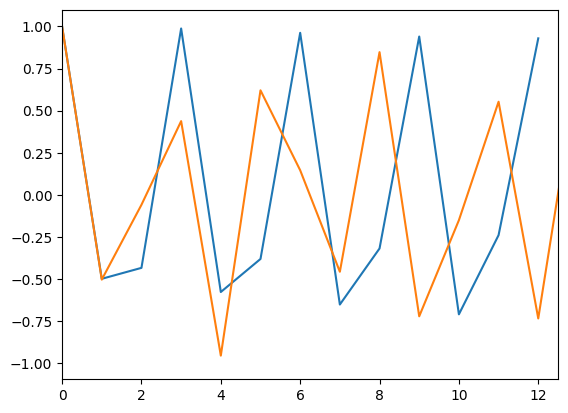

In [96]:
  
list_thingy = [ 1.        , -0.50425443, -0.05953301,  0.43753335, -0.95571017,
         0.62061202,  0.14564662, -0.4573758 ,  0.84735193, -0.72220735,
        -0.15115283,  0.55280423, -0.73490013,  0.75280894,  0.07299689,
        -0.6709995 ,  0.68059541, -0.69547962,  0.04555865,  0.74654017,
        -0.71448909,  0.58194848, -0.13890117, -0.73762376,  0.81782516,
        -0.47505639,  0.15536531,  0.6491805 , -0.93340998,  0.43396017,
        -0.08583887, -0.5301629 ,  0.99727007, -0.48140737, -0.03119688,
         0.44644251, -0.97406081,  0.59113702,  0.130964  , -0.44435653,
         0.8766297 , -0.70241531, -0.15825026,  0.52506327, -0.75889934,
         0.75365818,  0.09794759, -0.6438841 ,  0.68602994, -0.7164985 ,
         0.01656915,  0.73506427, -0.69835546,  0.61150458, -0.1219109 ,
        -0.74813696,  0.78905113, -0.49679043,  0.15978288,  0.67586011,
        -0.90792365,  0.43584211, -0.10921417, -0.55824432,  0.98917213,
        -0.46239708, -0.00179653,  0.46038475, -0.98783819,  0.5617536 ,
         0.111815  , -0.43644099,  0.90465395, -0.67892636, -0.15994687,
         0.49966624, -0.7856597 ,  0.74905854,  0.11955238, -0.61506997,
         0.69671872, -0.73333713, -0.0129911 ,  0.71877732, -0.68705536,
         0.64046318, -0.10076112, -0.75339148,  0.76201459, -0.52183771,
         0.15874602,  0.69974918, -0.88011431,  0.44311872, -0.12886805,
        -0.58754387,  0.97598664, -0.44787335,  0.02766642,  0.47888033,
        -0.99656964,  0.53347084,  0.08884938, -0.43389583,  0.93047043,
        -0.652536  , -0.15618735,  0.47749148, -0.8142744 ,  0.73916789,
         0.13708091, -0.58553555,  0.71229001, -0.74541797, -0.04210489,
         0.69823009, -0.68096396,  0.66782841, -0.07617466, -0.75320348,
         0.73763881, -0.54934304,  0.15229683,  0.72002614, -0.85093739]
plt.plot(s_ks[0])
plt.plot(list_thingy)
plt.xlim([0,12.5])

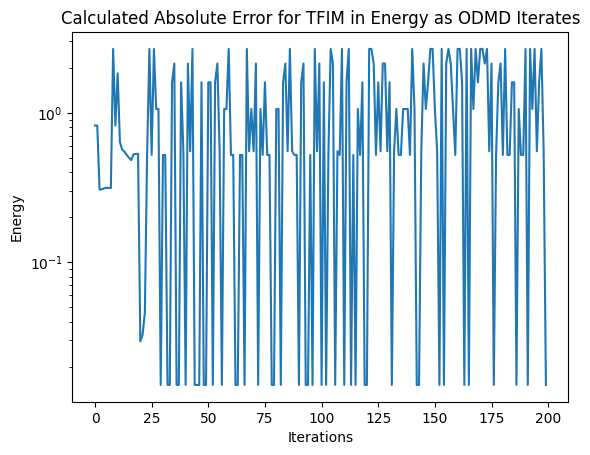

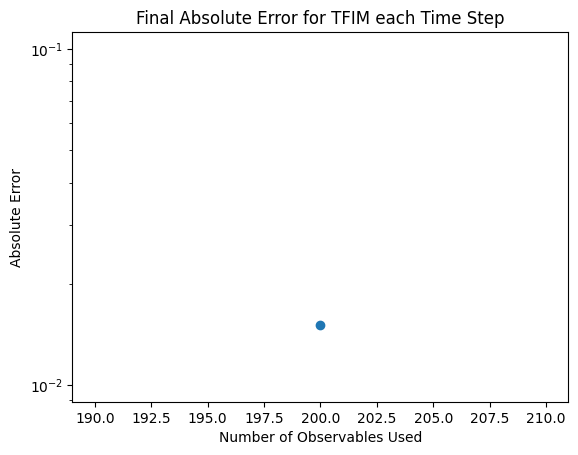

In [ ]:
if method_for_model[0].upper() == 'Q': real_E_0 = -scaling
else: real_E_0 = -1

for i in range(len(trials)):
    err = [abs(w-real_E_0) for w in trials[i]]
    # plt.plot(np.arange(0, 2*pi, time_steps[i])[0:len(trials[i])], err, label = 'Dt = '+str(time_steps[i]))
    plt.plot(range(len(err)), err, label = 'Dt = '+str(time_steps[i]))
plt.title("Calculated Absolute Error for "+system+" in Energy as ODMD Iterates")
plt.ylabel("Energy")
plt.xlabel("Iterations")
# plt.legend()
# plt.xlim([0,100])
# plt.ylim([0,10])
plt.yscale('log')
plt.savefig("Graphs/"+make_filename(computation_type, parameters)+"_Abs_Error.png")
plt.show()

plt.title("Final Absolute Error for "+system+" each Time Step")
plt.xlabel("Number of Observables Used")
plt.ylabel("Absolute Error")
plt.yscale('log')
observables = [len(w) for w in trials]
for i in range(len(results)):
    plt.scatter([observables[i]], [abs(real_E_0-results[i])], label = 'Dt = '+str(time_steps[i]))
plt.savefig("Graphs/"+make_filename(computation_type, parameters)+"_Final_Error.png")
# plt.legend()
plt.show()

In [98]:
print(len(results))
# print(time_steps)
print(results) 

1
[-2.685121926145123]
